# Results

In [1]:
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fmriprep_denoise.visualization import utils
from myst_nb import glue

path_root = utils.repo2data_path()

---- repo2data starting ----
/home/haoting/.virtualenvs/connectome_confounds/lib/python3.8/site-packages/repo2data
Config from file :
/home/haoting/projects/fmriprep-denoise-benchmark/binder/data_requirement.json
Destination:
../../inputs/fmrieprep-denoise-paper

Info : ../../inputs/fmrieprep-denoise-paper already downloaded


---- repo2data starting ----
/home/haoting/.virtualenvs/connectome_confounds/lib/python3.8/site-packages/repo2data
Config from file :
/home/haoting/projects/fmriprep-denoise-benchmark/binder/data_requirement.json
Destination:
../../inputs/fmrieprep-denoise-paper

Info : ../../inputs/fmrieprep-denoise-paper already downloaded


## Level of motion in samples quitified by mean framewise displacement

In [2]:
from statsmodels.stats.weightstats import ttest_ind

for_plotting = {}

dataset = "ds000228"
file = f"dataset-{dataset}_desc-movement_phenotype.tsv"
path_fd = path_root / f"dataset-{dataset}" / file
data = pd.read_csv(path_fd, header=[0], index_col=0, sep="\t")
_, participants_groups, _ = utils._get_participants_groups(dataset)
participants_groups.name = 'Groups'
data = pd.concat([data, participants_groups], axis=1, join='inner')
cat1 = data[data['Groups']=='child']
cat2 = data[data['Groups']=='adult']
t_stats, pval, df = ttest_ind(cat1['mean_framewise_displacement'], 
                              cat2['mean_framewise_displacement'],
                              usevar='unequal')
glue(f"{dataset}_t", t_stats)
glue(f"{dataset}_p", pval)
glue(f"{dataset}_df", df)
glue(f"{dataset}_child_mean", cat1['mean_framewise_displacement'].mean())
glue(f"{dataset}_child_sd", cat1['mean_framewise_displacement'].std())
glue(f"{dataset}_adult_mean", cat2['mean_framewise_displacement'].mean())
glue(f"{dataset}_adult_sd", cat2['mean_framewise_displacement'].std())

for_plotting.update({dataset: data})

5.9903509055012885

1.5099409407527793e-08

148.7509307996301

0.3726003847486127

0.28907597426004483

0.1881064928771293

0.09326558238655397

We will firstly characterise motion through the mean framewise displacement of each sample and the sub-groups. 
This report will serve as a reference point for understanding the remainder of the results.
There was a significant difference in motion during the scan captured by mean framewise displacement between the 
child (M = {glue:text}`ds000228_child_mean:.2f`, SD = {glue:text}`ds000228_child_sd:.2f`) 
and adult (M = {glue:text}`ds000228_adult_mean:.2f`, SD = {glue:text}`ds000228_adult_sd:.2f`) sample, 
t({glue:text}`ds000228_df:.2f`) = {glue:text}`ds000228_t:.2f`, p = {glue:text}`ds000228_p:.3f`,
This is consistent with the existing literature.

In [3]:
dataset = "ds000030"
file = f"dataset-{dataset}_desc-movement_phenotype.tsv"
path_fd = path_root / f"dataset-{dataset}" / file
data = pd.read_csv(path_fd, header=[0], index_col=0, sep="\t")
_, participants_groups, groups = utils._get_participants_groups(dataset)
participants_groups.name = 'Groups'
data = pd.concat([data['mean_framewise_displacement'], participants_groups], axis=1, join='inner')
baseline = data[data['Groups']=='CONTROL']
for group in groups:
    compare = data[data['Groups']==group]
    glue(f"{dataset}_{group}_mean", compare['mean_framewise_displacement'].mean())
    glue(f"{dataset}_{group}_sd", compare['mean_framewise_displacement'].std())

    if group != 'CONTROL':
        t_stats, pval, df = ttest_ind(baseline['mean_framewise_displacement'], 
                                      compare['mean_framewise_displacement'],
                                      usevar='unequal')
        glue(f"{dataset}_t_{group}", t_stats)
        glue(f"{dataset}_p_{group}", pval)
        glue(f"{dataset}_df_{group}", df)

for_plotting.update({dataset: data})

0.1481063793068254

0.09222778467046405

0.971585519173292

0.33364250271851514

98.25741154156053

0.18898841573626907

0.11204297777465377

-1.104984542831525

0.2716510957218563

106.72791464040314

0.2640663292252491

0.19496102391926312

-3.2249218047054766

0.0019222336876664097

69.42137384033886

0.16666143888934684

0.13508817731182263

In `ds000030`, the only patient group shows a difference comparing to the 
control (M = {glue:text}`ds000030_CONTROL_mean:.2f`, SD = {glue:text}`ds000030_CONTROL_sd:.2f`)
is the schizophrania group (M = {glue:text}`ds000030_SCHZ_mean:.2f`, SD = {glue:text}`ds000030_SCHZ_sd:.2f`; t({glue:text}`ds000030_df_SCHZ:.2f`) = {glue:text}`ds000030_t_SCHZ:.2f`, p = {glue:text}`ds000030_p_SCHZ:.3f`). 
There was no difference between the control and ADHD group(M = {glue:text}`ds000030_ADHD_mean:.2f`, SD = {glue:text}`ds000030_ADHD_sd:.2f`; t({glue:text}`ds000030_df_ADHD:.2f`) = {glue:text}`ds000030_t_ADHD:.2f`, p = {glue:text}`ds000030_p_ADHD:.3f`), 
or the bipolar group (M = {glue:text}`ds000030_BIPOLAR_mean:.2f`, SD = {glue:text}`ds000030_BIPOLAR_sd:.2f`; t({glue:text}`ds000030_df_BIPOLAR:.2f`) = {glue:text}`ds000030_t_BIPOLAR:.2f`, p = {glue:text}`ds000030_p_BIPOLAR:.3f`).

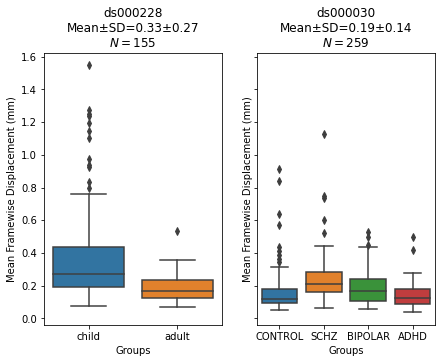

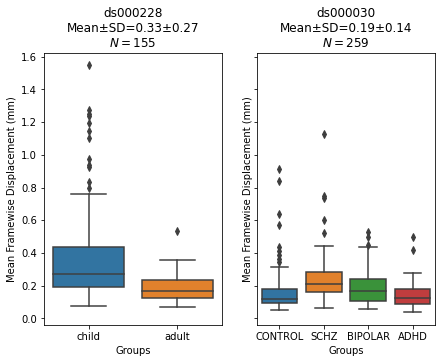

In [4]:
fig = plt.figure(figsize=(7, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(for_plotting, axs):
    df = for_plotting[dataset]
    mean_fd = df['mean_framewise_displacement'].mean()
    sd_fd = df['mean_framewise_displacement'].std()
    df = df.rename(columns={'mean_framewise_displacement': "Mean Framewise Displacement (mm)"})
    sns.boxplot(y='Mean Framewise Displacement (mm)',
                x='Groups',
                data=df,
                ax=ax)
    ax.set_title(f"{dataset}\nMean\u00B1SD={mean_fd:.2f}\u00B1{sd_fd:.2f}\n$N={df.shape[0]}$")
# fig.suptitle("Mean framewise displacement per sub-sample")

glue("meanFD-fig", fig, display=False)

```{glue:figure} meanFD-fig
:figwidth: 800px
:name: "tbl:meanFD-fig"

Mean framewise displacement of each dataset. 
We found the pattern described in the literature: 
young subjects has higher motion comparing to adults, 
and differences in different psychiatric groups.  
```


## The loss in temporal degrees of freedom in different strategies

The common analysis and denoising methods are based on linear reagression. 
Using more nuisance regressors can capture additional sources of noise-related variance in the data and thus improve denoising.
However, this comes at the expense of a loss of temporal degrees of freedom for statistical inference in furthe analysies.
This is an important point to consider along side the denoising performance.

---- repo2data starting ----
/home/haoting/.virtualenvs/connectome_confounds/lib/python3.8/site-packages/repo2data
Config from file :
/home/haoting/projects/fmriprep-denoise-benchmark/binder/data_requirement.json
Destination:
../../inputs/fmrieprep-denoise-paper

Info : ../../inputs/fmrieprep-denoise-paper already downloaded


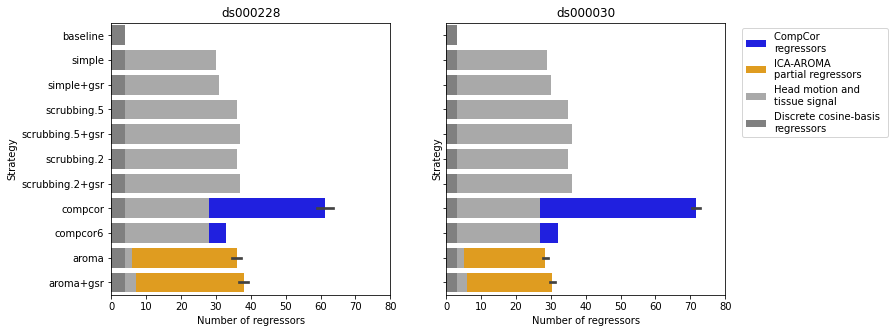

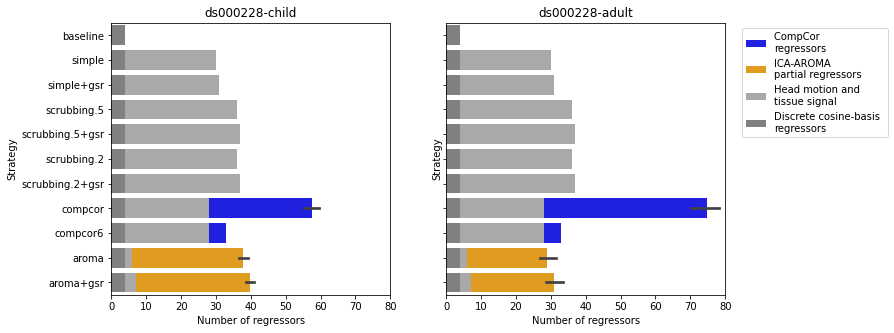

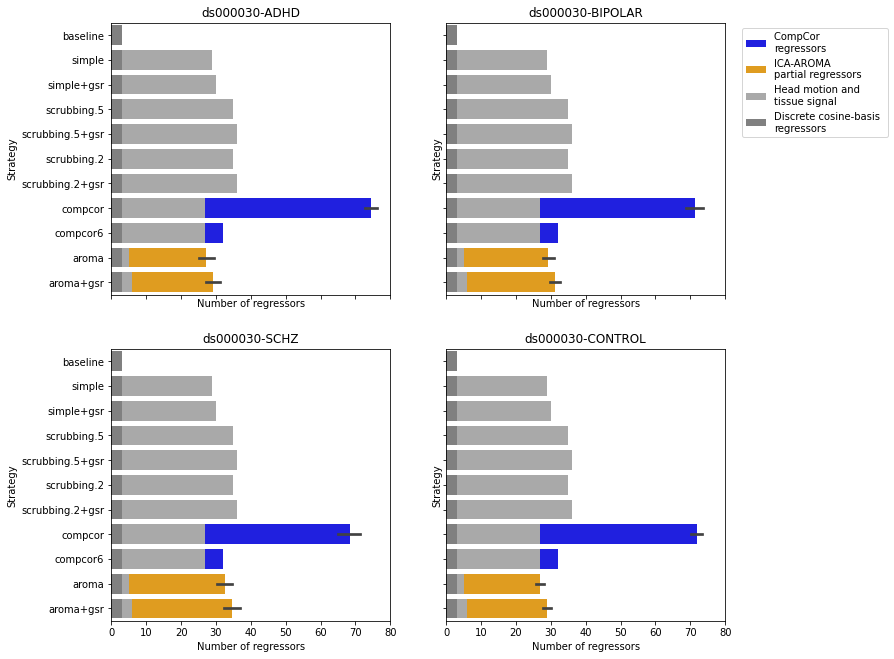

No handles with labels found to put in legend.


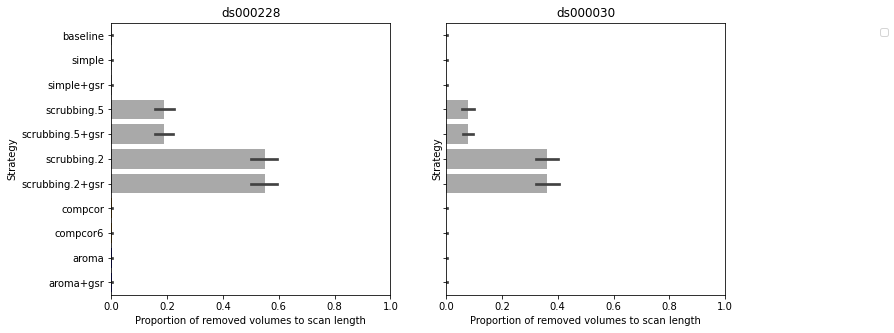

No handles with labels found to put in legend.


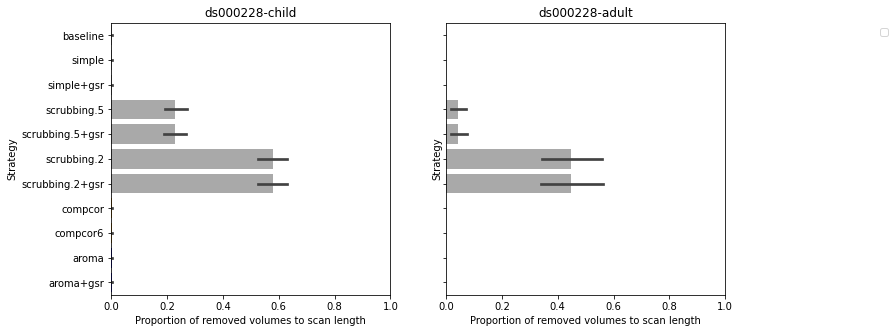

No handles with labels found to put in legend.


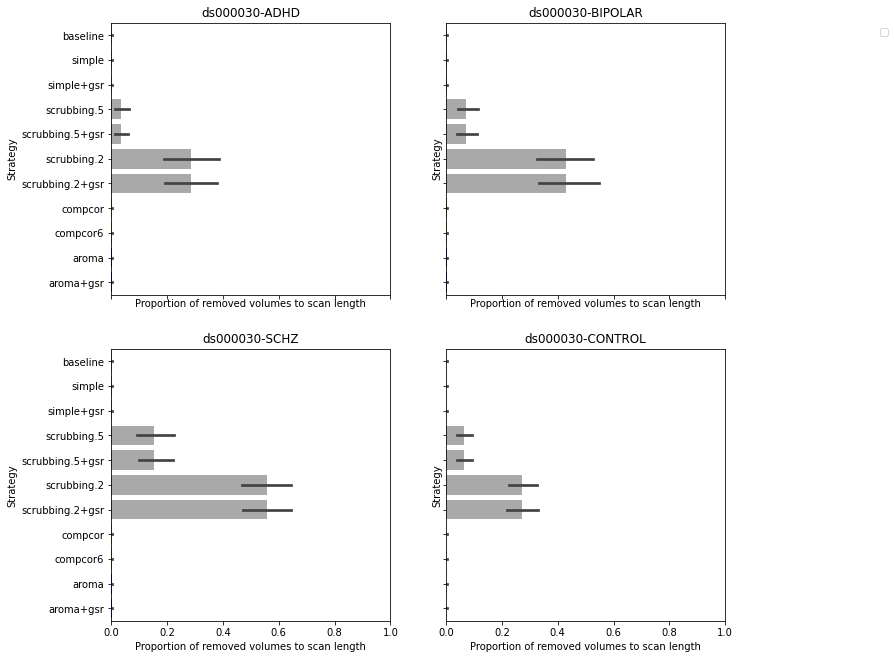

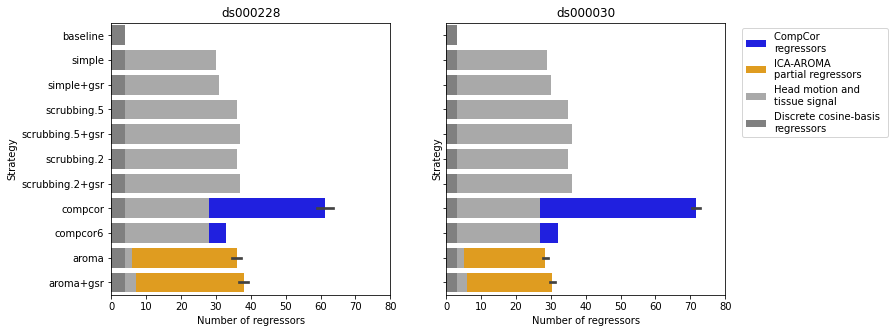

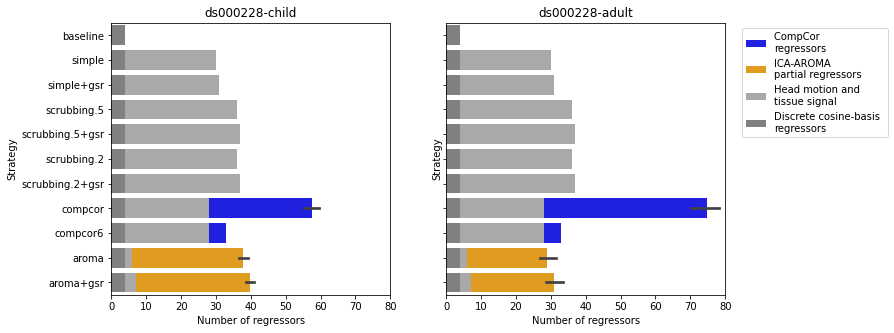

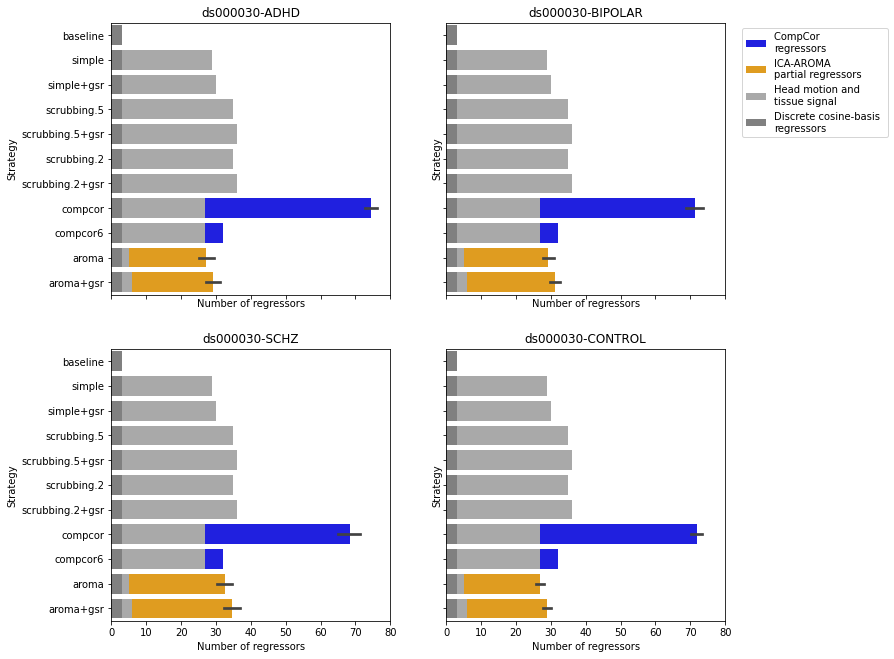

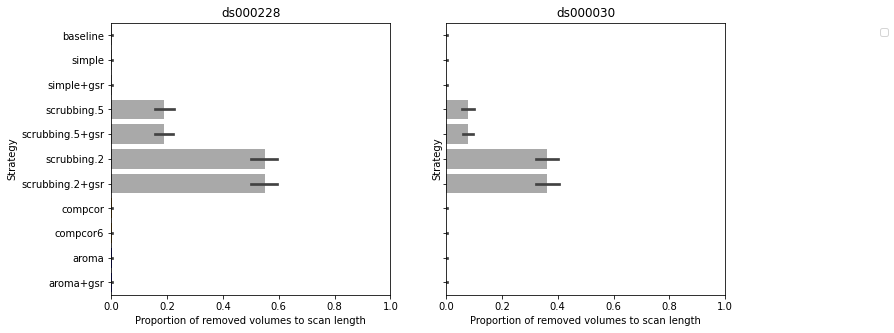

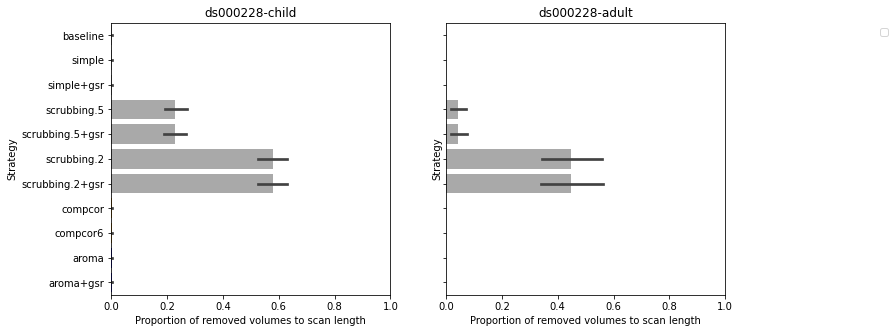

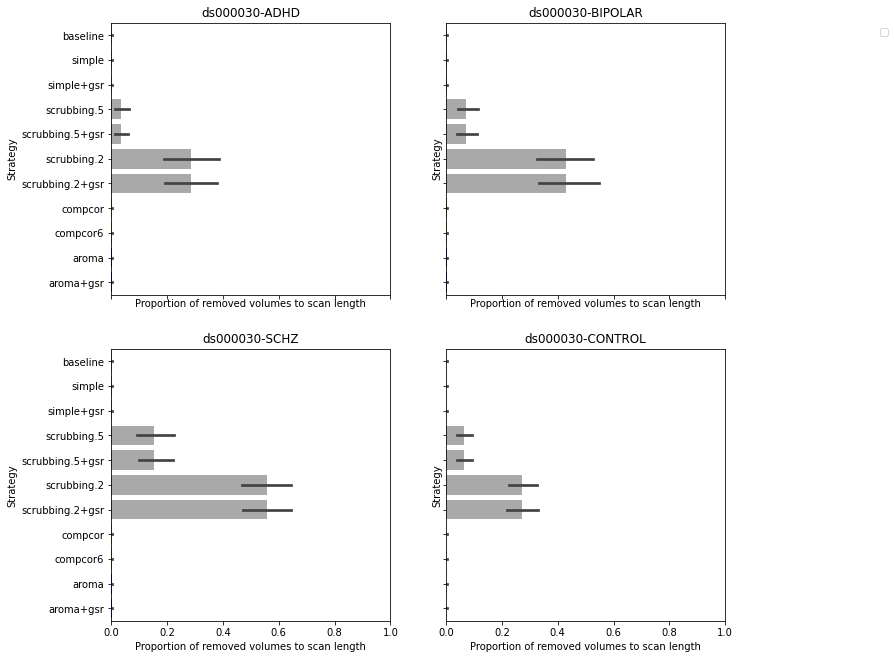

In [5]:
import warnings
warnings.filterwarnings("ignore")
from fmriprep_denoise.visualization import figures

from myst_nb import glue


plot_info = 'dof'

fig = figures.plot_dof_overview(plot_info)
glue("dof-fig", fig, display=False)

datasets = ["ds000228", "ds000030"]
for dataset in datasets:
    fig = figures.plot_dof_dataset(dataset, plot_info)
    glue(f"dof-{dataset}-fig", fig, display=False)

plot_info = 'scrubbing'

fig = figures.plot_dof_overview(plot_info)
glue("scrubbing-fig", fig, display=False)

datasets = ["ds000228", "ds000030"]
for dataset in datasets:
    fig = figures.plot_dof_dataset(dataset, plot_info)
    glue(f"scrubbing-{dataset}-fig", fig, display=False)

When selecting denoising strategy, the loss in degrees of freedom `simple` and `simple+gsr` used the least amount of regressors. 
In {cite:t}`ciric_benchmarking_2017`, the equivalent `aroma` and `aroma+gsr` strategies were reported with a lower magnitude of loss in temporal degrees of freedom than `scrubbing` or `simple` strategies.
However, we did not obser this advantage in the two datasets shown in this benchmark. 
The reason potentially lies in the implementation of ICA-AROMA.
ICA-AROMA uses pretrained model on healthy subjects to select noise components {cite:p}`aroma`. 
The two datasets used in the current benchmark both contained subjects with behaviours deviating from the healthy controls. 
`ds000228` is comprised of adult healthy controls and children. 
`ds000030` includes healthy controls and subjects with three different psychiatric conditions. 

The figures showed the number of regressors used at different stage of denoising. 
The `simple` and `srubbing`-based strategy and `compcor6` are the strategy with a fixed number of degree of freedom loss.
`compcor` and `aroma`-based strategies shows variability depending on the number of noise compoenets detected.

`````{tab-set}
````{tab-item} Overview
```{glue:figure} dof-fig
:figwidth: 800px
:name: "tbl:dof-fig"

Loss in temporal degrees of freedom in full sample of each dataset. 
```
````

````{tab-item} ds000228

```{glue:figure} dof-ds000228-fig
:figwidth: 800px
:name: "tbl:dof-ds000228-fig"

Loss in temporal degrees of freedom break down by groups. 
```
````

````{tab-item} ds000030
```{glue:figure} dof-ds000030-fig
:figwidth: 800px
:name: "tbl:dof-ds000030-fig"

Loss in temporal degrees of freedom break down by diagnostics. 
```
````

`````

To compare the loss in number of volumes from scrubbing base strategy across datasets, 
we calculate the proportion of volume loss to number of volumes in a full scan.
`ds000228` includes child subjects and shows higher loss in volumes comparing to `ds000030` with adult subjects only.
In `ds000228`, the trend of volume scrubbed comparing adults and children fits the observation shown in literature {cite:p}`satterthwaite_impact_2012`. 
In `ds000030`, the schizophrania group shows the highest amount of volumes scrubbed, followed by the biolar group, and comparable results betwee the control group and ADHD group.
With a stringent 0.2 mm threashold, groups with high motion will loose on average close to half of the volumes.

<!-- The figure below can be further trimmed down. -->

`````{tab-set}

````{tab-item} Overview
```{glue:figure} scrubbing-fig
:figwidth: 800px
:name: "tbl:scrubbing-fig"

Loss in number of volumes in full sample of each dataset. 
```
````

````{tab-item} ds000228

```{glue:figure} scrubbing-ds000228-fig
:figwidth: 800px
:name: "tbl:scrubbing-ds000228-fig"

Loss in temporal degrees of freedom break down by groups. 
```
````

````{tab-item} ds000030
```{glue:figure} scrubbing-ds000030-fig
:figwidth: 800px
:name: "tbl:scrubbing-ds000030-fig"

Loss in number of volumes break down by diagnostics. 
```
````

`````


## Comparisons on the impacts of strategies on connectomes

The trend of benchmaker metrics does not differ amongst the choice of atlases.
However, we can see variance within the parcellation scheme MIST and DiFuMo.
The variance comes from different resolution of the same parcellation scheme, epecially with low parcel counts.

:::{dropdown} References on this page

```{bibliography}
:filter: docname in docnames
```
:::